In [1]:
import os
import decouple
config = decouple.AutoConfig(' ')
os.chdir(config('ROOT_DIRECTORY'))
import sys
sys.path.insert(0, '')

from loaders.local import DataHandler as dh
from preprocessing.feature_builders import PredictorFeaturesBuilder as pfb

import pandas as pd
import numpy as np
from scipy.stats import norm, gamma

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None

# Feature Building

In this notebook we'll prepare the dataset for modelling. The features that we're going to build fall into 3 categories:

1. Static venue features for each runner (these are known at the start of the race and are the same for each runner)

index: RaceDate, FasttrackRaceId
- Race distance (normalised)
- Race grade
- Track condition (data unavailable?)
- Historical win proportion of each box

2. Static runner features (these are known at the start of the race)

index: RaceDate, FasttrackRaceId, FasttrackDogId
- Weight
- Box number
- Whether adjacent boxes are empty

3. Inferred runner features (these are computed after the race then estimated for the upcoming race using time series methods on that dog's previous races)
- Average Speed
- Boolean "is winner?"
- Win probability (or StartPrice)
- Type of start based on "PIR" (too many missing/inconsistent values)

4. Trainer features (will be important for new runners)
- Win proportion of all runners trained by that trainer

Note:
- Throughout the notebook "dog" and "runner" are used interchangeably

In [2]:
data = dh.get_train_data()
data = data.set_index(['RaceDate', 'FasttrackRaceId', 'FasttrackDogId', 'TrainerId'])
data

Place          DogName  \
RaceDate   FasttrackRaceId FasttrackDogId TrainerId                           
2018-07-01 335811282       157500927      7683           1      RAINE ALLEN   
                           1820620018     137227         2       SURF A LOT   
                           1950680026     132763         3      PINGIN' BEE   
                           1524380048     116605         4  LUCAS THE GREAT   
                           124225458      132763         5            QUAVO   
...                                                    ...              ...   
2021-11-30 734778635       614057722      69407          4   INFAMOUS ANGEL   
           734778636       576142623      130513         1   ROISIN MONELLI   
                           540582677      130351         2   RAPIDO CHA CHA   
                           580792922      102994         3  TIGGERLONG FOOT   
           734778637       504470931      92464          1      GLOBAL GAIN   

                                                     Box  Rug  Weight  \
RaceDate   FasttrackRaceId FasttrackDogId TrainerId                     
2018-07-01 335811282       157500927      7683         1    1    27.4   
                           1820620018     137227       2    2    32.8   
                           1950680026     132763       6    6    25.5   
                           1524380048     116605       7    7    32.2   
                           124225458      132763       4    4    28.9   
...                                                  ...  ...     ...   
2021-11-30 734778635       614057722      69407        3    3    25.0   
           734778636       576142623      130513       1    1    29.1   
                           540582677      130351       7    7    26.1   
                           580792922      102994       5    5    25.5   
           734778637       504470931      92464        1    1    32.3   

                                                     StartPrice  Margin1  \
RaceDate   FasttrackRaceId FasttrackDogId TrainerId                        
2018-07-01 335811282       157500927      7683              2.4     2.30   
                           1820620018     137227            6.3     2.30   
                           1950680026     132763            9.3     3.84   
                           1524380048     116605            9.1     5.27   
                           124225458      132763            3.4     5.56   
...                                                         ...      ...   
2021-11-30 734778635       614057722      69407             NaN    12.25   
           734778636       576142623      130513            NaN     1.00   
                           540582677      130351            NaN     1.00   
                           580792922      102994            NaN     6.00   
           734778637       504470931      92464             NaN      NaN   

                                                     Margin2    PIR  Checks  \
RaceDate   FasttrackRaceId FasttrackDogId TrainerId                           
2018-07-01 335811282       157500927      7683           NaN  Q/111       0   
                           1820620018     137227        2.30  M/332       0   
                           1950680026     132763        1.54  S/443       0   
                           1524380048     116605        1.43  M/655       5   
                           124225458      132763        0.29  M/766       8   
...                                                      ...    ...     ...   
2021-11-30 734778635       614057722      69407         0.14      2       0   
           734778636       576142623      130513         NaN     11       0   
                           540582677      130351        1.14     32       0   
                           580792922      102994        4.86     23       0   
           734778637       504470931      92464          NaN    111       0   

                                                     Split

# Venue Features

## Static Venue Features

In [3]:
def get_static_venue_features(data):
    sv_features = data[['Distance']]
    sv_features.index = sv_features.index.droplevel(['FasttrackDogId', 'TrainerId'])
    sv_features = sv_features.reset_index().drop_duplicates().set_index(['RaceDate', 'FasttrackRaceId'])

    distance_scaler = MinMaxScaler()
    sv_features['Distance'] = distance_scaler.fit_transform(sv_features[['Distance']])

    return sv_features

sv_features = get_static_venue_features(data)
sv_features

Distance
RaceDate   FasttrackRaceId          
2018-07-01 335811282        0.492341
           335811293        0.328228
           335811292        0.328228
           335811291        0.328228
           335811288        0.328228
...                              ...
2021-11-30 734778633        0.054705
           734778634        0.059081
           734778635        0.059081
           734778636        0.284464
           734778637        0.470460

[106942 rows x 1 columns]

### Examine `Distance` feature

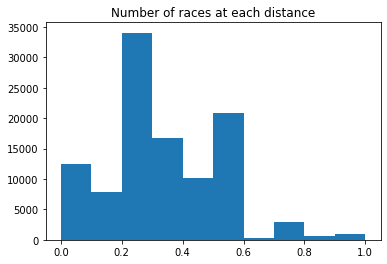

In [4]:
plt.hist(sv_features['Distance'])
plt.title("Number of races at each distance")
plt.show()

### Examine `RaceGrade` feature

Homework: read more on `RaceGrade` to find how to make it useful

In [5]:
data['RaceGrade'].value_counts().head(15)

Grade 5               159194
Mixed 4/5              63442
Maiden                 61772
Grade 6                52374
Grade 5 T3             28921
Grade 5 Heat           27808
Restricted Win         25506
Mixed 6/7              20624
Novice Grade 5         19591
Maiden Heat            18391
Novice Non Penalty     17585
Free For All           17519
Mixed 3/4              13571
Grade 4                13255
Open                   11931
Name: RaceGrade, dtype: int64

## Inferred Venue Features

In [6]:
def get_inferred_venue_features(data):
    box_win_proportion_column_names = [f"Box_{i}_WP" for i in range(1, 9)]

    iv_features = data[['Place', 'Box', 'TrackDist']].copy()
    iv_features = iv_features.set_index('TrackDist', append = True)
    iv_features.index = iv_features.index.droplevel(['FasttrackDogId', 'TrainerId'])
    iv_features['IsWinner'] = (iv_features.Place == 1).astype(int)
    iv_features = iv_features.drop(columns = ['Place'])
    iv_features = iv_features.reset_index().pivot(index = iv_features.index.names, columns = ['Box'], values = ['IsWinner']).fillna(0)
    iv_features.columns = box_win_proportion_column_names

    return iv_features

iv_features = get_inferred_venue_features(data)
iv_features

Box_1_WP  Box_2_WP  Box_3_WP  \
RaceDate   FasttrackRaceId TrackDist                                      
2018-07-01 334309830       Sale440              0.0       1.0       0.0   
           334309949       Albion Park331       0.0       0.0       0.0   
           334309950       Albion Park331       0.0       0.0       0.0   
           334309951       Albion Park331       0.0       0.0       1.0   
           334309952       Albion Park331       0.0       1.0       0.0   
...                                             ...       ...       ...   
2021-11-30 735164901       Warragul400          1.0       0.0       0.0   
           735164902       Warragul460          0.0       0.0       0.0   
           735164903       Warragul460          1.0       0.0       0.0   
           735164904       Warragul460          1.0       0.0       0.0   
           735164905       Warragul460          1.0       0.0       0.0   

                                           Box_4_WP  Box_5_WP  Box_6_WP  \
RaceDate   FasttrackRaceId TrackDist                                      
2018-07-01 334309830       Sale440              0.0       0.0       0.0   
           334309949       Albion Park331       1.0       0.0       0.0   
           334309950       Albion Park331       0.0       0.0       0.0   
           334309951       Albion Park331       0.0       0.0       0.0   
           334309952       Albion Park331       0.0       0.0       0.0   
...                                             ...       ...       ...   
2021-11-30 735164901       Warragul400          0.0       0.0       0.0   
           735164902       Warragul460          0.0       0.0       0.0   
           735164903       Warragul460          0.0       0.0       0.0   
           735164904       Warragul460          0.0       0.0       0.0   
           735164905       Warragul460          0.0       0.0       0.0   

                                           Box_7_WP  Box_8_WP  
RaceDate   FasttrackRaceId TrackDist                           
2018-07-01 334309830       Sale440              0.0       0.0  
           334309949       Albion Park331       0.0       0.0  
           334309950       Albion Park331       0.0       1.0  
           334309951       Albion Park331       0.0       0.0  
           334309952       Albion Park331       0.0       0.0  
...                                             ...       ...  
2021-11-30 735164901       Warragul400          0.0       0.0  
           735164902       Warragul460          0.0       1.0  
           735164903       Warragul460          0.0       0.0  
           735164904       Warragul460          0.0       0.0  
           735164905       Warragul460          0.0       0.0  

[106942 rows x 8 columns]

In [7]:
def get_estimated_venue_features(data):
    box_win_proportion_column_names = [f"Box_{i}_WP" for i in range(1, 9)]
    first_num_races_to_discard = 24

    iv_features = get_inferred_venue_features(data)

    ev_features = iv_features.copy()
    ev_features['RaceNumber'] = 1.0
    ev_features = ev_features.groupby(level = [2]).cumsum()
    ev_features[box_win_proportion_column_names] = ev_features[box_win_proportion_column_names].div(ev_features.RaceNumber.values, axis = 0)

    ev_features = ev_features[ev_features.RaceNumber > first_num_races_to_discard]
    ev_features = ev_features.drop(columns = ['RaceNumber'])

    return ev_features

ev_features = get_estimated_venue_features(data)
ev_features

Box_1_WP  Box_2_WP  Box_3_WP  \
RaceDate   FasttrackRaceId TrackDist                                     
2018-07-04 334310032       Angle Park388  0.200000  0.240000  0.000000   
2018-07-06 336623545       Cannington380  0.280000  0.080000  0.200000   
           337785741       Bendigo425     0.280000  0.120000  0.160000   
2018-07-07 336623549       Cannington380  0.269231  0.076923  0.192308   
           336623567       Cannington380  0.259259  0.074074  0.185185   
...                                            ...       ...       ...   
2021-11-30 735164901       Warragul400    0.157564  0.136221  0.131513   
           735164902       Warragul460    0.178199  0.149289  0.112796   
           735164903       Warragul460    0.178588  0.149218  0.112743   
           735164904       Warragul460    0.178977  0.149148  0.112689   
           735164905       Warragul460    0.179366  0.149077  0.112636   

                                          Box_4_WP  Box_5_WP  Box_6_WP  \
RaceDate   FasttrackRaceId TrackDist                                     
2018-07-04 334310032       Angle Park388  0.040000  0.160000  0.040000   
2018-07-06 336623545       Cannington380  0.080000  0.120000  0.080000   
           337785741       Bendigo425     0.080000  0.080000  0.120000   
2018-07-07 336623549       Cannington380  0.076923  0.115385  0.115385   
           336623567       Cannington380  0.074074  0.111111  0.111111   
...                                            ...       ...       ...   
2021-11-30 735164901       Warragul400    0.107659  0.094476  0.110169   
           735164902       Warragul460    0.107109  0.097156  0.112796   
           735164903       Warragul460    0.107058  0.097110  0.112743   
           735164904       Warragul460    0.107008  0.097064  0.112689   
           735164905       Warragul460    0.106957  0.097018  0.112636   

                                          Box_7_WP  Box_8_WP  
RaceDate   FasttrackRaceId TrackDist                          
2018-07-04 334310032       Angle Park388  0.120000  0.200000  
2018-07-06 336623545       Cannington380  0.080000  0.080000  
           337785741       Bendigo425     0.080000  0.080000  
2018-07-07 336623549       Cannington380  0.076923  0.076923  
           336623567       Cannington380  0.111111  0.074074  
...                                            ...       ...  
2021-11-30 735164901       Warragul400    0.116447  0.147834  
           735164902       Warragul460    0.118957  0.125592  
           735164903       Warragul460    0.118901  0.125533  
           735164904       Warragul460    0.118845  0.125473  
           735164905       Warragul460    0.118788  0.125414  

[104045 rows x 8 columns]

### Examine convergence of box win percentages

- it seems that dropping the first 25 races at each venue is too little, may need to drop a few hundred
- or they could be estimated using the whole training data
- some lines seem to stabalize, no problems with using the whole training data to estimate these
- other lines show slight upward or downward trend, may consider using only last N races to estimate these


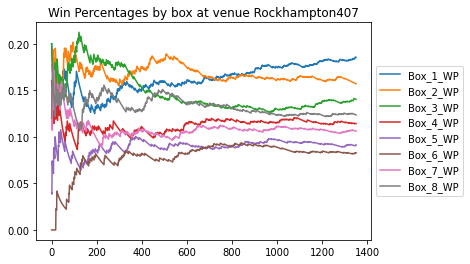

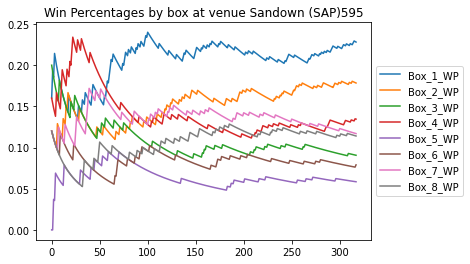

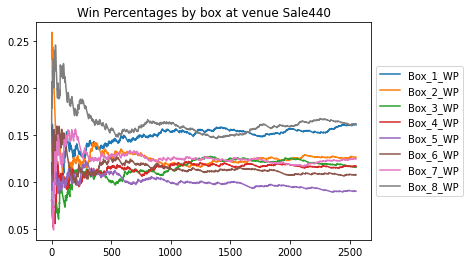

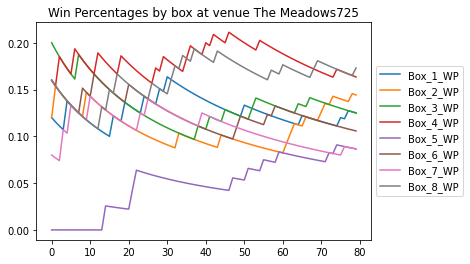

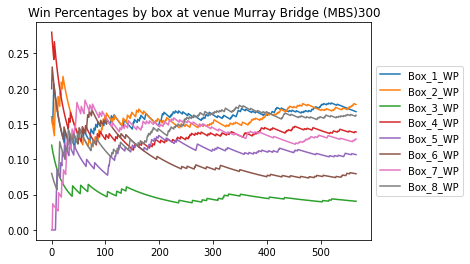

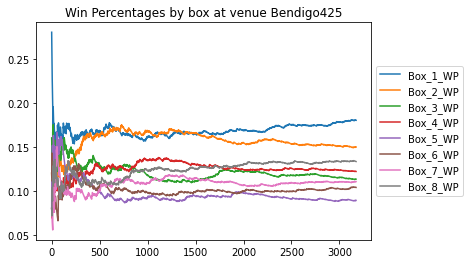

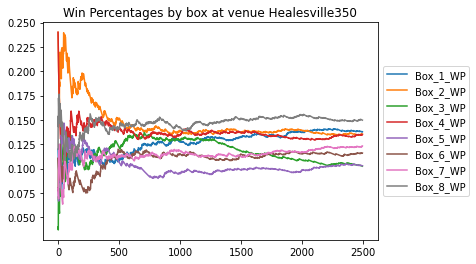

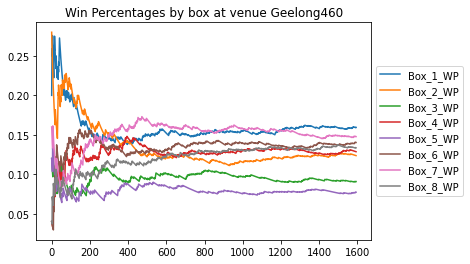

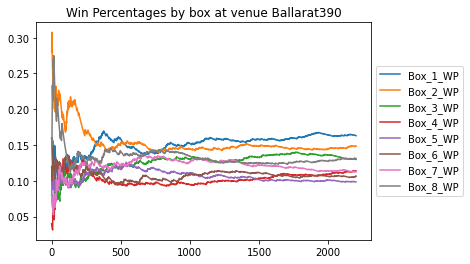

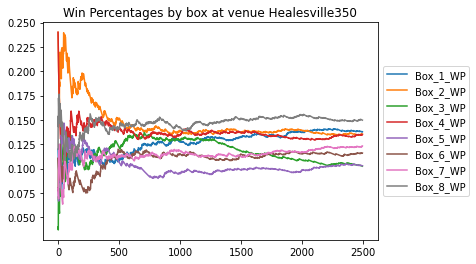

In [8]:
seed = np.random.RandomState(8)
for i in range(10):
    random_track_dist = seed.choice(ev_features.index.get_level_values('TrackDist'))
    random_track_dist

    ev_features[ev_features.index.get_level_values('TrackDist') == random_track_dist].reset_index(drop = True).plot()
    plt.legend(
        loc = 'center left',
        bbox_to_anchor = (1, 0.5)
    )
    plt.title(f"Win Percentages by box at venue {random_track_dist}")
    plt.show()

## Final dataset

In [9]:
def get_venue_features(data):
    v_features = data[['Distance']]
    v_features.index = v_features.index.droplevel(['FasttrackDogId', 'TrainerId'])
    v_features = v_features.reset_index().drop_duplicates().set_index(['RaceDate', 'FasttrackRaceId'])

    distance_scaler = MinMaxScaler()
    v_features['Distance'] = distance_scaler.fit_transform(v_features[['Distance']])

    return v_features

v_features = get_venue_features(data)
v_features

Distance
RaceDate   FasttrackRaceId          
2018-07-01 335811282        0.492341
           335811293        0.328228
           335811292        0.328228
           335811291        0.328228
           335811288        0.328228
...                              ...
2021-11-30 734778633        0.054705
           734778634        0.059081
           734778635        0.059081
           734778636        0.284464
           734778637        0.470460

[106942 rows x 1 columns]

# Runner Features

## Static Runner Features

In [10]:
def get_static_runner_features(data):

    sr_features = data[['Box', 'Weight']].copy()
    sr_features.index = sr_features.index.droplevel('TrainerId')

    sr_features = sr_features.reset_index().set_index(['RaceDate', 'FasttrackRaceId', 'Box', 'FasttrackDogId']).sort_index().reset_index('Box')
    sr_features['HasInsideNeighbour'] = np.insert(sr_features.Box[1:].values == sr_features.Box[:-1].values + 1, 0, 0) * 1
    sr_features['HasOutsideNeighbour'] = np.append(sr_features.Box[1:].values == sr_features.Box[:-1].values + 1, 0) * 1

    one_hot_encoder = OneHotEncoder()
    sr_features[[f"Box_{i}" for i in range(1, 9)]] = one_hot_encoder.fit_transform(sr_features[['Box']]).toarray()
    sr_features = sr_features.drop(columns = ['Box'])

    standard_scaler = StandardScaler()
    sr_features['Weight'] = standard_scaler.fit_transform(sr_features[['Weight']])

    sr_features['RacesCompleted'] = 1
    sr_features['RacesCompleted'] = sr_features.groupby(sr_features.index.get_level_values('FasttrackDogId'))['RacesCompleted'].cumsum() - 1
    
    return sr_features

sr_features = get_static_runner_features(data)
sr_features

Weight  HasInsideNeighbour  \
RaceDate   FasttrackRaceId FasttrackDogId                                 
2018-07-01 334309830       196374475       0.591269                   0   
                           119991023       0.441686                   1   
                           160105572       1.040019                   1   
                           184224214       0.770769                   1   
                           131736468      -1.652480                   1   
...                                             ...                 ...   
2021-11-30 735164905       438202679      -0.545564                   1   
                           536729322      -0.844730                   1   
                           550747962       1.159686                   0   
                           524412240       0.890436                   1   
                           570556341      -0.784897                   0   

                                           HasOutsideNeighbour  Box_1  Box_2  \
RaceDate   FasttrackRaceId FasttrackDogId                                      
2018-07-01 334309830       196374475                         1    1.0    0.0   
                           119991023                         1    0.0    1.0   
                           160105572                         1    0.0    0.0   
                           184224214                         1    0.0    0.0   
                           131736468                         1    0.0    0.0   
...                                                        ...    ...    ...   
2021-11-30 735164905       438202679                         1    0.0    1.0   
                           536729322                         0    0.0    0.0   
                           550747962                         1    0.0    0.0   
                           524412240                         0    0.0    0.0   
                           570556341                         0    0.0    0.0   

                                           Box_3  Box_4  Box_5  Box_6  Box_7  \
RaceDate   FasttrackRaceId FasttrackDogId                                      
2018-07-01 334309830       196374475         0.0    0.0    0.0    0.0    0.0   
                           119991023         0.0    0.0    0.0    0.0    0.0   
                           160105572         1.0    0.0    0.0    0.0    0.0   
                           184224214         0.0    1.0    0.0    0.0    0.0   
                           131736468         0.0    0.0    1.0    0.0    0.0   
...                                          ...    ...    ...    ...    ...   
2021-11-30 735164905       438202679         0.0    0.0    0.0    0.0    0.0   
                           536729322         1.0    0.0    0.0    0.0    0.0   
                           550747962         0.0    0.0    1.0    0.0    0.0   
                           524412240         0.0    0.0    0.0    1.0    0.0   
                           570556341         0.0    0.0    0.0    0.0    0.0   

                                           Box_8  RacesCompleted  
RaceDate   FasttrackRaceId FasttrackDogId                         
2018-07-01 334309830       196374475         0.0               0  
                           119991023         0.0               0  
                           160105572         0.0               0  
                           184224214         0.0               0  
                           131736468         0.0               0  
...                                          ...             ...  
2021-11-30 735164905       438202679         0.0               8  
                           536729322         0.0               1  
                           550747962         0.0               6  
                           524412240         0.0               0  
                           570556341         1.0               2  

[763167 rows x 12 columns]

### Examine `Weight` feature

Two peaks can be explained by dog's gender.

Bitches are generally lighter than dogs (https://www.greyhoundpredictor.com/prediction/page8.html). Need to collect gender data!

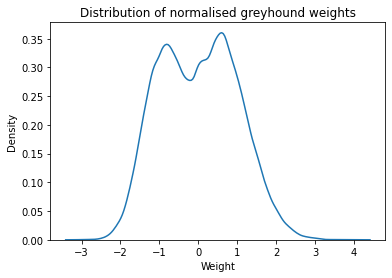

In [11]:
sns.kdeplot(sr_features['Weight'])
plt.title("Distribution of normalised greyhound weights")
plt.show()

## Inferred Runner Features

In [12]:
def get_inferred_runner_features(data):

    ir_features = pd.DataFrame()

    average_speed_scaler = StandardScaler()
    ir_features['AverageSpeed'] = data.Distance / data.RunTime
    ir_features['AverageSpeed'] = average_speed_scaler.fit_transform(ir_features[['AverageSpeed']])

    ir_features['IsWinner'] = (data.Place == 1).astype(int)

    ir_features['InvertedPrice'] = np.reciprocal(data.StartPrice).fillna(0)

    return ir_features

ir_features = get_inferred_runner_features(data)
ir_features

AverageSpeed  IsWinner  \
RaceDate   FasttrackRaceId FasttrackDogId TrainerId                           
2018-07-01 335811282       157500927      7683           0.878388         1   
                           1820620018     137227         0.648973         0   
                           1950680026     132763         0.492722         0   
                           1524380048     116605         0.351703         0   
                           124225458      132763         0.323616         0   
...                                                           ...       ...   
2021-11-30 734778635       614057722      69407         -1.673493         0   
           734778636       576142623      130513         0.498488         1   
                           540582677      130351         0.359165         0   
                           580792922      102994        -0.222529         0   
           734778637       504470931      92464          0.523646         1   

                                                     InvertedPrice  
RaceDate   FasttrackRaceId FasttrackDogId TrainerId                 
2018-07-01 335811282       157500927      7683            0.416667  
                           1820620018     137227          0.158730  
                           1950680026     132763          0.107527  
                           1524380048     116605          0.109890  
                           124225458      132763          0.294118  
...                                                            ...  
2021-11-30 734778635       614057722      69407           0.000000  
           734778636       576142623      130513          0.000000  
                           540582677      130351          0.000000  
                           580792922      102994          0.000000  
           734778637       504470931      92464           0.000000  

[763167 rows x 3 columns]

In [14]:
def estimate_inferred_runner_features(runner_history_data):
    """
    For each feature returns the value from that runner's previous race
    """
    result = np.empty_like(runner_history_data)
    result[:1] = 0
    result[1:] = runner_history_data[:-1]

    return result

def get_estimated_runner_features(data):
    ir_features = get_inferred_runner_features(data)
    er_features = ir_features.groupby(ir_features.index.get_level_values('FasttrackDogId')).transform(lambda t: estimate_inferred_runner_features(t.to_numpy()))
    return er_features

er_features = get_estimated_runner_features(data)
er_features

AverageSpeed  IsWinner  \
RaceDate   FasttrackRaceId FasttrackDogId TrainerId                           
2018-07-01 335811282       157500927      7683           0.000000         0   
                           1820620018     137227         0.000000         0   
                           1950680026     132763         0.000000         0   
                           1524380048     116605         0.000000         0   
                           124225458      132763         0.000000         0   
...                                                           ...       ...   
2021-11-30 734778635       614057722      69407         -0.989164         0   
           734778636       576142623      130513         0.000000         0   
                           540582677      130351         0.000000         0   
                           580792922      102994        -0.882855         0   
           734778637       504470931      92464          0.117618         0   

                                                     InvertedPrice  
RaceDate   FasttrackRaceId FasttrackDogId TrainerId                 
2018-07-01 335811282       157500927      7683            0.000000  
                           1820620018     137227          0.000000  
                           1950680026     132763          0.000000  
                           1524380048     116605          0.000000  
                           124225458      132763          0.000000  
...                                                            ...  
2021-11-30 734778635       614057722      69407           0.000000  
           734778636       576142623      130513          0.000000  
                           540582677      130351          0.000000  
                           580792922      102994          0.099010  
           734778637       504470931      92464           0.108696  

[763167 rows x 3 columns]

### Examine normal fit to `AverageSpeed`

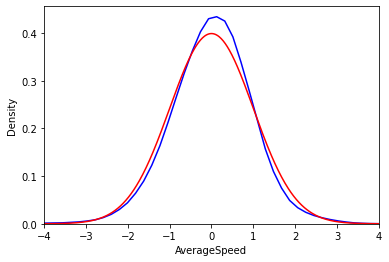

In [15]:

mu = ir_features.AverageSpeed.mean()
sd = ir_features.AverageSpeed.std()
xs = np.linspace(-4, 4, 500)

sns.kdeplot(ir_features.AverageSpeed, color = 'blue')
plt.plot(xs, norm.pdf(xs, loc = mu, scale = sd), color = 'red')
plt.xlim((-4, 4))
plt.show()

### Examine `AverageSpeed` vs number of races

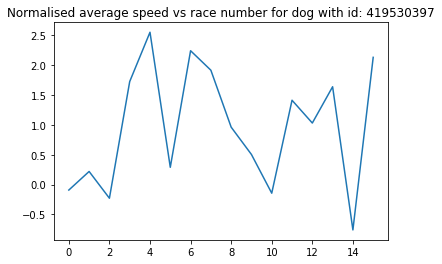

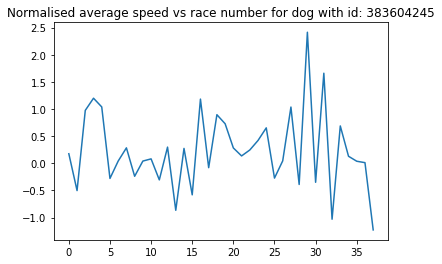

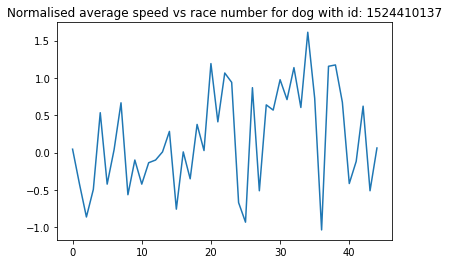

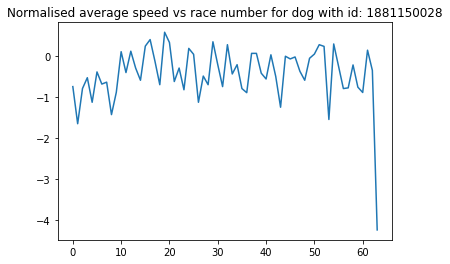

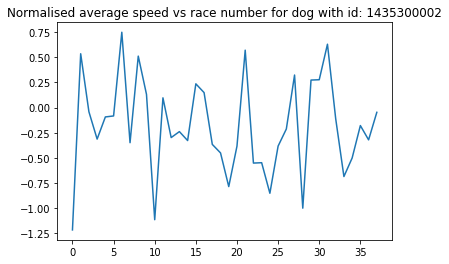

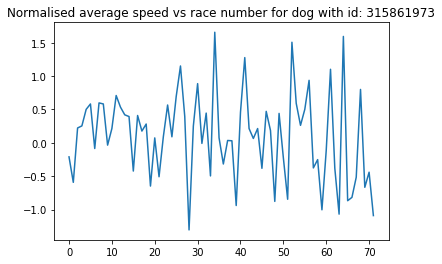

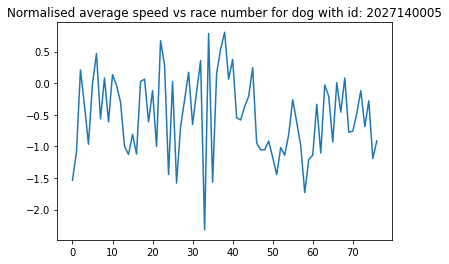

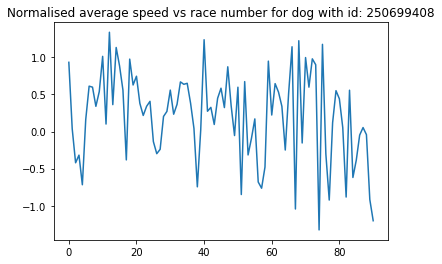

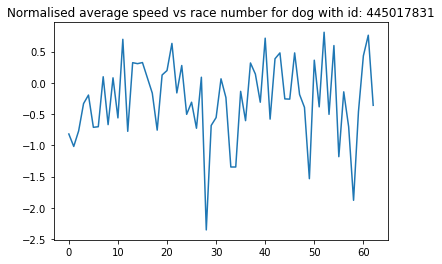

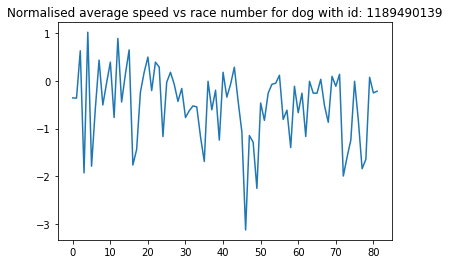

In [16]:
seed = np.random.RandomState(8)
for _ in range(10):
    random_dog_id = seed.choice(ir_features.index.get_level_values('FasttrackDogId'))

    racing_history = ir_features[ir_features.index.get_level_values('FasttrackDogId') == random_dog_id]

    plt.plot([i for i in range(len(racing_history))], racing_history.AverageSpeed)
    plt.title(f"Normalised average speed vs race number for dog with id: {random_dog_id}")
    plt.show()

## Final Dataset

# Trainer Features